# Federated learning monitoring

### Check how FedAvg is doing at its best 
- Sanity check for federated setup 
- Baseline for improvement strategies

In [9]:
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
%matplotlib inline

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
import json
from flower.task import Net
from plot_utils import plot_n_outputs

In [45]:
fed_avg = glob.glob(f"../results_federated_learningtest_hyperparam/**/federated_training/FedAvg/150_rounds/**/results.json", recursive=True)
len(fed_avg)

94

In [43]:
fed_avg

['../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_64_clipping_False_lrdecay_1.0_localepochs_3_decayonset_10/federated_outputs/results.json',
 '../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_16_clipping_False_lrdecay_1.0_localepochs_3_decayonset_10/federated_outputs/results.json',
 '../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_16_clipping_False_lrdecay_1.0_localepochs_3_decayonset_10/federated_outputs/results.json',
 '../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_16_clipping_False_lrdecay_1.0_localepochs_3_decayonset_15/federated_outputs/results.json',
 '../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsiz

In [46]:
def read_loss_file(file):
    # Read the meta.csv file
    meta_file = file.replace("results.json", "meta.csv")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    clipping = meta_data['gradientclipping'].item()
    lrdecay = meta_data['lrdecay'].item()
    nlocalepochs = meta_data['localepochs'].item()
    
    # Read the results.json file
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Plot centralized evaluate
    df_centralized_evaluate = pd.DataFrame(data['centralized_evaluate'])
    df_federated_evaluate = pd.DataFrame(data['federated_evaluate'])
    # Add the learning rate to the DataFrame
    df_federated_evaluate['lr'] = lr
    df_centralized_evaluate['lr'] = lr
    # Add the batch size to the DataFrame
    df_federated_evaluate['batch_size'] = batch_size
    df_centralized_evaluate['batch_size'] = batch_size
    # Add the clipping to the DataFrame
    df_federated_evaluate['clipping'] = clipping
    df_centralized_evaluate['clipping'] = clipping
    # add decay
    df_federated_evaluate['lrdecay'] = lrdecay
    df_centralized_evaluate['lrdecay'] = lrdecay
    # add nlocalepochs
    df_federated_evaluate['localepochs'] = nlocalepochs
    df_centralized_evaluate['localepochs'] = nlocalepochs
    # add decay onset 
    df_federated_evaluate['decay_onset'] = meta_data['decay_onset'].item()
    df_centralized_evaluate['decay_onset'] = meta_data['decay_onset'].item()

    # Aggregation column 
    # Check if file contins "FedAvg" in the path name
    if "FedAvg" in file:
        # if the path name contains "FedAvg" then add aggregation column "FedAvg"
        df_federated_evaluate['aggregation'] = "FedAvg"
        df_centralized_evaluate['aggregation'] = "FedAvg"
    else:
        # if the path name does not contain "FedAvg" then add aggregation column "FedProx"
        df_federated_evaluate['aggregation'] = "FedODE"
        df_centralized_evaluate['aggregation'] = "FedODE"


    # if the path name contains "FedAvg" then add aggregation column "FedAvg"
    df_federated_evaluate['hyperparameters'] = df_federated_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}, lrdecay: {x['lrdecay']}, nlocalepochs: {x['localepochs']}", axis=1)
    df_centralized_evaluate['hyperparameters'] = df_centralized_evaluate.apply(lambda x: f"lr: {x['lr']}, batch_size: {x['batch_size']}, clipping: {x['clipping']}, lrdecay: {x['lrdecay']}, nlocalepochs: {x['localepochs']}", axis=1)
    # combine lr, batch size and clipping into one column

    df_federated_evaluate['type'] = "federated"
    df_centralized_evaluate['type'] = "centralized"

    # modify centralized_loss into loss
    df_centralized_evaluate.rename(columns={'centralized_loss': 'loss'}, inplace=True)
    # modify federated_loss into loss
    df_federated_evaluate.rename(columns={'federated_evaluate_loss': 'loss'}, inplace=True)

    return df_centralized_evaluate, df_federated_evaluate

In [48]:
df_centralized_evaluate = pd.DataFrame()
df_federated_evaluate = pd.DataFrame()
for file in fed_avg:
    df_centralized_evaluate_temp, df_federated_evaluate_temp = read_loss_file(file)
    df_centralized_evaluate = pd.concat([df_centralized_evaluate, df_centralized_evaluate_temp])
    df_federated_evaluate = pd.concat([df_federated_evaluate, df_federated_evaluate_temp])
# plot the loss
# plot the loss by hyperparameters
# merge the two dataframes
# append dataframes
df = pd.concat([df_centralized_evaluate, df_federated_evaluate])
#df

In [49]:
df[df['lr'] == 0.001]["batch_size"].unique()

array([64, 16, 32])

<Figure size 1000x300 with 0 Axes>

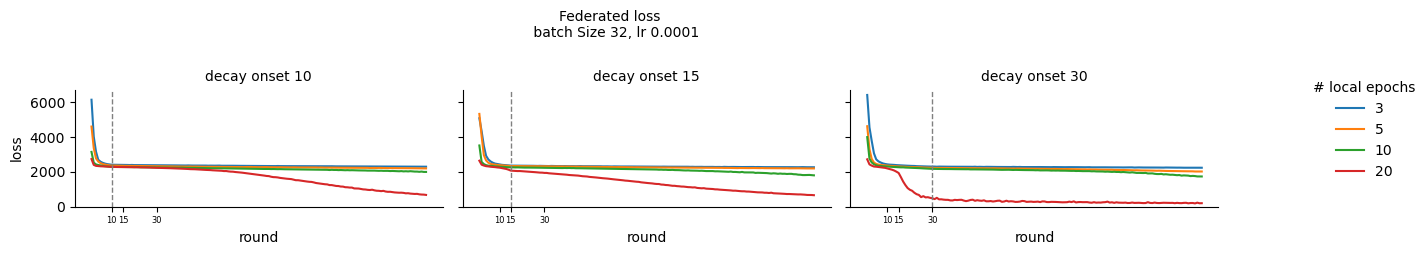

In [198]:
# Filter only the rows relevant for loss comparison
loss_df = df[df['type'].isin(["centralized", "federated"])]

# Keep centralized loss (federated is quite similar, we can double check later)

# Remove learning rate 0.01
lr = 0.0001
bs = 32
type = "federated"
loss_df = loss_df[loss_df['type'] == type]
loss_df = loss_df[loss_df['lr'] == lr]
loss_df = loss_df[loss_df['batch_size'] == bs]

# fig size
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    loss_df,
    col="decay_onset",
    height=2.5,
    aspect=1.5,  # Width = height * aspect
    sharey=True
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='round',
    y='loss',
    hue='localepochs',
    palette='tab10'
)

# Adjustments
g.set_axis_labels("round", "loss")
g.set_titles("decay onset {col_name}")
g.set(ylim=(0, None))



# Set x-ticks
for ax in g.axes.flat:
    ax.set_xticks([10,15,30])
    # also label the x-ticks
    ax.set_xticklabels([10,15,30], size = 6)
    # vertical line on decay onset x 
    # extract the current deacay onset from the title
    decay_onset = ax.get_title().split(" ")[-1]
    ax.axvline(x=int(decay_onset), color='grey', linestyle='--', label='Decay Onset', linewidth=1)

# Move legend outside
g.add_legend(title ="# local epochs")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
g.fig.suptitle(f"Federated loss  \n batch Size {bs}, lr {lr}", fontsize=10, y=1.00)
plt.tight_layout()
plt.show()


# Zoom in into the clients

In [12]:
def plot_client_loss(file, type_loss ="train_loss", nrounds=None):

    # Load JSON file
    with open(file, "r") as f:
        data = json.load(f)


    # extarct from the file name the lr, batchsize, nlocalepochs, clipping, lrdecay
    # remove the last part of the file name
    file_path = file.replace("results_0.json", "")
    file_path = file_path.replace("results_1.json", "")
    meta_file = file_path + "meta.csv"
    print(f"Loading meta data from {meta_file}")
    meta_data = pd.read_csv(meta_file)
    lr = meta_data['lr'].item()
    batch_size = meta_data['batch_size'].item()
    clipping = meta_data['gradientclipping'].item()
    lrdecay = meta_data['lrdecay'].item()
    nlocalepochs = meta_data['localepochs'].item()
    decay_onset = meta_data['decay_onset'].item()
    title = f"lr: {lr}, batch_size: {batch_size}, nlocalepochs: {nlocalepochs}, decay_onset: {decay_onset}"

    # Extract loss values, rounds, and epochs
    loss_values = []
    rounds = []
    epochs = []

    epoch_count = 0  # To keep track of epochs

    for entry in data["client_train"]:
        round_number = entry["round"]
        for loss in entry[type_loss]:
            rounds.append(round_number)
            loss_values.append(loss)
            epochs.append(epoch_count)
            epoch_count += 1

    if nrounds is not None:
        # Filter the data to only include the first n rounds
        filtered_indices = [i for i, r in enumerate(rounds) if r < nrounds]
        loss_values = [loss_values[i] for i in filtered_indices]
        rounds = [rounds[i] for i in filtered_indices]
        epochs = [epochs[i] for i in filtered_indices]

    # make it smaller 
    plt.figure(figsize=(10, 2.5))
    # Plot loss values sequentially across rounds and epochs
    plt.plot(epochs, loss_values, marker='o', label="Loss across epochs", markersize=2)

    # add 1 to the round
    # Add verl lines for each round number
    for round_number in set(rounds):
        round_epochs = [i for i, r in enumerate(rounds) if r == round_number]
        if round_epochs:
            # Place a vertical line at the first epoch of each round
            # if it is not the first round
            if round_number != 0:
                plt.axvline(x=round_epochs[0], color='grey', linestyle='--', label=f"Round {round_number}", alpha=0.5, linewidth=1)

    # Customize x-axis ticks to represent rounds
    xticks = [i for i, round_number in enumerate(rounds) if i == 0 or rounds[i] != rounds[i-1]]
    # plot it only every 10th round
    xticks = [i for i in xticks if i % 100 == 0 or i == 0]
    plt.xticks(xticks, [rounds[i] for i in xticks])
    # log scale y 
    plt.title(title)
    plt.ylim(bottom=0)
    plt.xlabel("Round")
    plt.ylabel(f"Local {type_loss}")
    plt.tight_layout()
    plt.show()


In [185]:
files = [f.replace("results.json", "") for f in fed_avg]
files = [f + "results_*.json" for f in files]
files = [glob.glob(f, recursive=True) for f in files]
len(files)

94

Loading meta data from ../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_30/federated_outputs/meta.csv


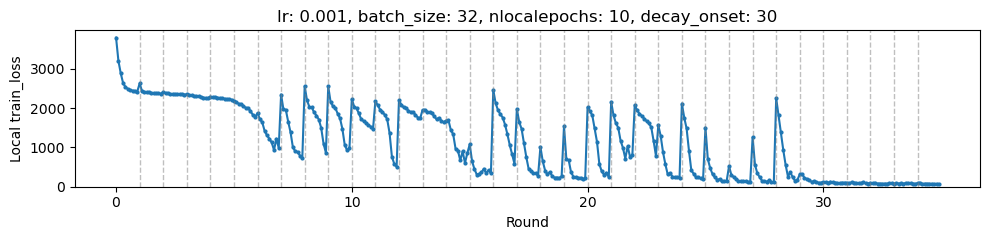

Loading meta data from ../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_30/federated_outputs/meta.csv


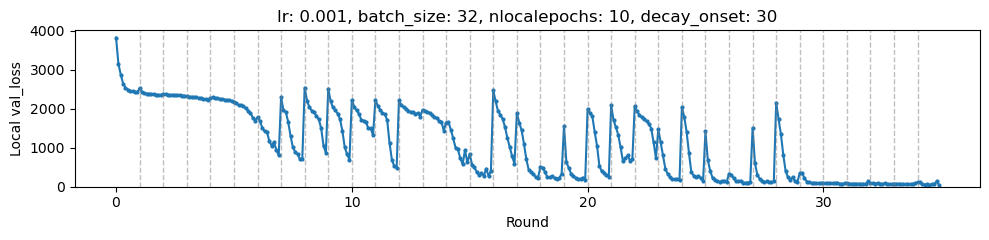

In [193]:
client_file = '../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_30/federated_outputs/results_1.json'
n = 35
plot_client_loss(client_file, type_loss = "train_loss", nrounds = n)
plot_client_loss(client_file, type_loss = "val_loss", nrounds = n)

<Figure size 200x150 with 0 Axes>

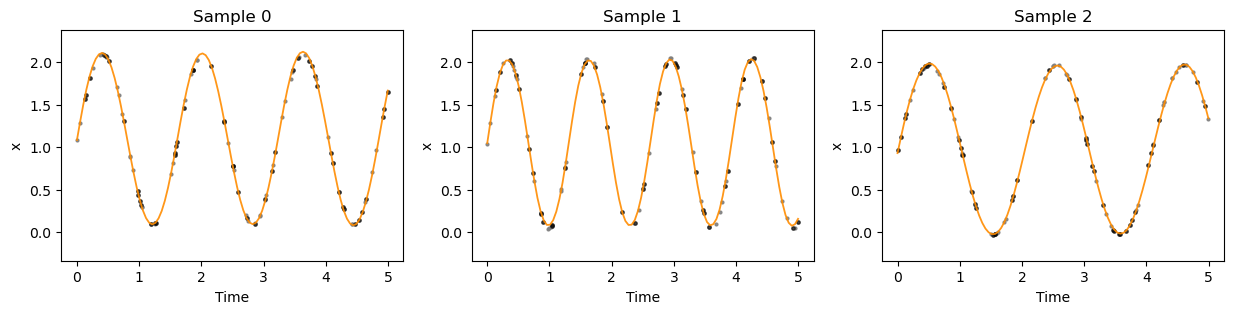

 lr 0.001, batch size 32, local epochs 10, decay onset 30


In [197]:
#############################
# Load Dataset
#############################
test_dataset_filename = "../data/periodic/periodic_test.pt"
time_steps_filename = "../data/periodic/periodic_time_steps.pt"
timestamps = torch.load(time_steps_filename, weights_only=True)
dataset = torch.load(test_dataset_filename, weights_only=True)
%matplotlib inline

weigths = "../results_federated_learningtest_hyperparam/periodic/federated_training/FedAvg/150_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_10_decayonset_30/federated_outputs/model.pth"
model = Net()
# load meta 
meta_file = weigths.replace("model.pth", "meta.csv")
meta_data = pd.read_csv(meta_file)
lr = meta_data['lr'].item()
batch_size = meta_data['batch_size'].item()
decay_onset = meta_data['decay_onset'].item()
local_epochs = meta_data['localepochs'].item()

plt.figure(figsize=(2, 1.5))
# before training
model.load_state_dict(torch.load(weigths, weights_only=True))

plot_n_outputs(model, dataset, timestamps, n = 3 )
print(f" lr {lr}, batch size {batch_size}, local epochs {local_epochs}, decay onset {decay_onset}")